<a href="https://colab.research.google.com/github/paper-prism/paper-prism/blob/main/paper-prism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [8]:
# 이 패키지는 메모리와 성능 최적화를 위한 수치 연산 라이브러리로, 특히 FP16/INT8 처리를 지원하여 대규모 모델의 메모리 사용량을 줄이는 데 유용함
!pip3 install -q -U bitsandbytes

# PEFT는 Parameter-Efficient Fine-Tuning의 약자로, 대형 언어 모델을 미세 조정할 때 적은 수의 파라미터만을 조정하는 방법을 제공하여 훈련 시간을 줄여주는 패키지
!pip3 install -q -U peft

# trl은 Transformer Reinforcement Learning의 약자로, 강화 학습을 Transformer 기반 모델과 결합하여 훈련하는 데 사용되는 패키지
!pip3 install -q -U trl==0.7.10

# 이 패키지는 분산 및 가속화된 학습을 간편하게 할 수 있도록 도와주는 도구로, 특히 여러 GPU나 TPU에서 훈련할 때 유용함
!pip3 install -q -U accelerate==0.27.1

# datasets는 다양한 자연어 처리 데이터셋을 쉽게 로드하고 처리할 수 있게 해주는 Hugging Face의 데이터셋 라이브러리
!pip3 install -q -U datasets==2.17.0

# Hugging Face의 transformers는 BERT, GPT 등 다양한 사전 훈련된 언어 모델을 불러와 사용할 수 있게 해주는 라이브러리로, NLP 작업을 손쉽게 수행 가능
!pip3 install -q -U transformers==4..0


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [9]:
!nvidia-smi

Sat Sep 21 09:52:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# pandas 라이브러리를 pd라는 별칭으로 불러옴
# pandas는 데이터 분석을 위한 Python 라이브러리로, 데이터프레임을 쉽게 다룰 수 있도록 도와줌
import pandas as pd

# Hugging Face의 datasets 모듈에서 Dataset 클래스와 load_dataset 함수를 불러옴
# Dataset 클래스는 데이터셋을 관리하는 객체이며, load_dataset 함수는 Hugging Face 허브에서 다양한 데이터셋을 로드하는 데 사용됨
from datasets import Dataset, load_dataset

# Hugging Face 허브에 로그인하기 위한 함수
# notebook_login은 Hugging Face의 모델 및 데이터셋을 사용할 때, 사용자 인증을 돕는 함수
from huggingface_hub import notebook_login

# peft(Prompt-Efficient Fine-Tuning) 모듈에서 LoraConfig와 PeftModel을 불러옴
# LoraConfig는 LoRA (Low-Rank Adaptation)의 설정을 정의하는 클래스이고, PeftModel은 파라미터 효율적 미세 조정이 적용된 모델을 나타냄
from peft import LoraConfig, PeftModel

# transformers 모듈에서 필요한 객체들을 불러옴
# AutoModelForCausalLM은 사전 학습된 causal language model을 자동으로 로드하는 클래스
# AutoTokenizer는 사전 학습된 토크나이저를 자동으로 로드하는 클래스
# BitsAndBytesConfig는 8비트 연산 최적화를 위한 설정을 담은 클래스
# TrainingArguments는 훈련 시 사용할 설정들을 담는 클래스
# pipeline은 Hugging Face의 사전 학습된 모델을 손쉽게 불러와 다양한 작업에 사용할 수 있게 해주는 유틸리티 함수
# logging은 transformers의 로깅 도구로, 로그 출력을 관리할 수 있음
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)

# trl(Transformer Reinforcement Learning) 모듈에서 SFTTrainer를 불러옴
# SFTTrainer는 Supervised Fine-Tuning을 위한 트레이너 클래스로, 사전 학습된 언어 모델을 미세 조정할 때 사용
from trl import SFTTrainer

import torch


# Model Loading

In [4]:
notebook_login()

In [7]:
# 주석으로 처리된 여러 model_id 중에서 'google/gemma-2b-it' 모델을 선택
# 이 모델은 Gemma의 2B 파라미터 모델로, 'it'는 instruction tuning이 된 버전을 의미
# instruction 모델은 일반 base 모델과 달리 특정 작업을 위한 지시(명령어) 템플릿을 포함하고 있음
# model_id = "google/gemma-7b-it"
# model_id = "google/gemma-7b"
model_id = "google/gemma-2b-it"
# model_id = "google/gemma-2b"

# BitsAndBytesConfig 설정을 사용하여 모델을 4비트로 양자화함
# load_in_4bit=True: 모델을 4비트로 로드해 메모리 사용량을 줄임
# bnb_4bit_use_double_quant=True: 이중 양자화를 사용해 모델의 메모리 효율을 더 높임
# bnb_4bit_quant_type="nf4": 양자화 유형을 NF4로 설정 (효율적인 수치 표현 방식 중 하나)
# bnb_4bit_compute_dtype=torch.bfloat16: 계산 시 bfloat16 데이터 타입을 사용해 계산 정확도를 유지하면서 속도를 높임
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 선택한 모델을 AutoModelForCausalLM을 통해 로드함
# from_pretrained() 메소드를 사용해 사전 학습된 모델을 로드하고, 양자화 설정(bnb_config)을 적용함
# device_map={"":0}: 모델이 GPU의 첫 번째 장치(장치 번호 0)에서 실행되도록 지정
model = AutoModelForCausalLM.from_pretrained(
    model_id, quantization_config=bnb_config,
    device_map={"":0}
)

# 선택한 모델에 맞는 토크나이저를 로드함
# from_pretrained() 메소드를 통해 모델과 동일한 사전 학습된 토크나이저를 불러옴
# add_eos_toekn=True: 문장 끝에 EOS(end of sentence) 토큰을 자동으로 추가하는 설정
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_toekn=True)


ValueError: The checkpoint you are trying to load has model type `gemma2` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

In [6]:
def get_completion(query: str, model, tokenizer) -> str:
    # 모델을 실행할 장치를 설정 (GPU 사용)
    device = "cuda:0"

    # 프롬프트 템플릿 정의
    # 사용자와 모델 간의 대화를 시뮬레이션하는 형식으로, 'user'의 명령어에 대해 'model'이 응답하는 구조
    prompt_template = """
    <start_of_turn>user
    Below is an instruction that describes a task. Write a response that appropriately completes the request.

    Instruction:
    {query}
    <end_of_turn>\n<start_of_turn>model
    """

    # 주어진 query(질의)를 프롬프트 템플릿에 삽입
    # 사용자로부터 받은 질문이나 명령어가 프롬프트 내 'Instruction' 자리에 삽입됨
    prompt = prompt_template.format(query=query)

    # 토크나이저를 사용하여 프롬프트를 토큰화
    # return_tensors="pt": PyTorch 텐서 형식으로 반환
    # add_special_tokens=True: 모델에 필요한 특별 토큰(EOS, PAD 등)을 추가
    encodes = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)

    # 토큰화된 입력을 지정된 장치(GPU)에 올림
    model_inputs = encodes.to(device)

    # 모델을 사용해 응답을 생성
    # generate() 함수는 주어진 입력에 대한 텍스트를 생성
    # max_new_tokens=1000: 생성할 최대 토큰 수를 1000으로 설정
    # do_sample=True: 샘플링을 통해 다양성을 가진 응답을 생성 (그리디 서치 대신 사용)
    # pad_token_id=tokenizer.eos_token_id: 패딩 토큰으로 EOS(end of sentence) 토큰을 사용
    generated_ids = model.generate(**model_inputs, max_new_tokens=500, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    # 모델이 생성한 토큰을 디코딩하여 텍스트로 변환
    # batch_decode() 대신 decode()로 하나의 응답만 디코딩
    # skip_special_tokens=True: 디코딩 시 특별 토큰(EOS, PAD 등)을 무시
    decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # 디코딩된 텍스트(모델의 응답)를 반환
    return decoded


In [7]:
# 'code the fibonacci series in python using recursion'라는 질의를 모델에게 보내고 결과를 반환받는 함수 호출
result = get_completion(query="code the fibonacci series in python using recursion", model=model, tokenizer=tokenizer)

# 모델이 반환한 결과(응답)를 출력
print(result)



    user
    Below is an instruction that describes a task. Write a response that appropriately completes the request.

    Instruction:
    code the fibonacci series in python using recursion
    
model
    ```python
    def fibonacci(n):
        if n <= 1:
            return n
        else:
            return fibonacci(n-1) + fibonacci(n-2)


    # Print the first 10 numbers in the Fibonacci sequence
    for i in range(10):
        print(fibonacci(i))
```

**Output:**

```
0
1
1
2
3
5
8
13
21
34
55
```


# Load & Format The Dataset

Spend 80% of my time curating the data and coming up with the right format with the dataset and 20% of the time in fineting

Preparing Data for fine tuning

In [12]:
import os
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. .kaggle 디렉토리 생성
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# 2. kaggle.json 파일 복사
source_file = 'kaggle.json'  # 현재 작업 디렉토리에 있는 kaggle.json 파일 이름
destination_file = os.path.join(kaggle_dir, 'kaggle.json')

# 현재 디렉토리에 kaggle.json 파일이 있는지 확인
if not os.path.exists(source_file):
    raise FileNotFoundError(f"{source_file} 파일이 현재 디렉토리에 존재하지 않습니다. kaggle.json 파일을 올바른 위치에 두었는지 확인해주세요.")

# 파일 복사
shutil.copy(source_file, destination_file)

# 3. kaggle.json 파일의 권한을 600으로 설정 (읽기 및 쓰기 권한)
os.chmod(destination_file, 0o600)

# 4. Kaggle API 초기화 및 인증
api = KaggleApi()
api.authenticate()

# 5. Kaggle 데이터셋 다운로드
dataset_name = 'nelgiriyewithana/emotions'  # 다운로드할 데이터셋 이름
destination_path = '.'  # 다운로드할 위치 (현재 디렉토리)

# 데이터셋 다운로드
api.dataset_download_files(dataset_name, path=destination_path, unzip=True)

print("데이터셋 다운로드 완료!")

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
데이터셋 다운로드 완료!


In [14]:
data = pd.read_csv('/content/text.csv', index_col = 0)

data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [15]:
# drop_duplicates() 메서드를 사용하여 데이터프레임 'text'에서 중복된 행을 제거합니다.
# ignore_index=True 옵션은 중복 제거 후 인덱스를 재설정합니다.
# inplace=True 옵션은 원본 데이터프레임을 직접 수정하여 중복 행을 제거합니다.
data.drop_duplicates(ignore_index=True, inplace=True)

print(f'shape: {data.shape}')
print('\n')
print(f'isnull: \n{data.isnull().sum()}')
print('\n')
print(f'duplicated: {data.duplicated().sum()}')

shape: (416123, 2)


isnull: 
text     0
label    0
dtype: int64


duplicated: 0


In [17]:
data.tail()

,text,label
416118,i feel like telling these horny devils to find...,2
416119,i began to realize that when i was feeling agi...,3
416120,i feel very curious be why previous early dawn...,5
416121,i feel that becuase of the tyranical nature of...,3
416122,i think that after i had spent some time inves...,5


In [18]:
# 감정(label) 매핑을 정의한 딕셔너리입니다.
# 각 키는 'label' 값이고, 각 값은 해당 감정에 해당하는 문자열입니다.
emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# 'label' 열의 값을 emotions 딕셔너리의 값으로 대체하여 새로운 'emotion' 열을 만듭니다.
# data['label'] 열의 각 값이 emotions 딕셔너리의 키와 일치하면 해당 키의 값(감정)이 'emotion' 열에 대입됩니다.
data['emotion'] = data['label'].replace(emotions)

# 데이터프레임의 상위 5개의 행을 출력하여 변경 사항을 확인합니다.
# 'emotion' 열에 매핑된 감정 문자열이 잘 적용되었는지 확인할 수 있습니다.
data.head()

,text,label,emotion
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


<ipython-input-19-6c032e928e56>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs, palette="viridis")


Text(0.5, 1.0, 'Count of Categories')

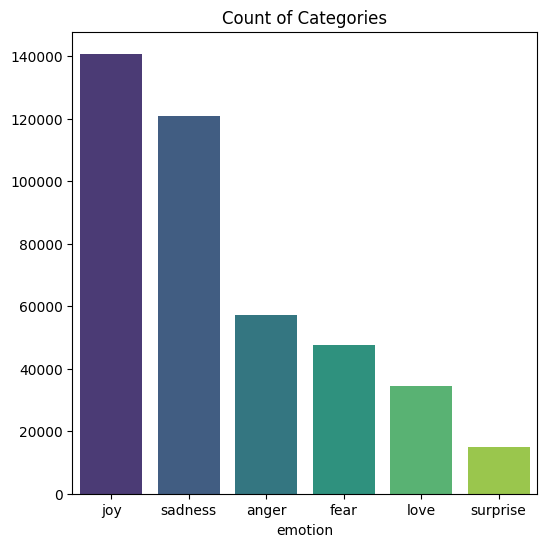

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

# emotion category 시각화
count = data['emotion'].value_counts()

fig, axs = plt.subplots(figsize = (6, 6), facecolor='white')
palette = sns.color_palette("viridis")
sns.set_palette(palette)

sns.barplot(x=count.index, y=count.values, ax=axs, palette="viridis")
axs.set_title('Count of Categories')

In [ ]:
# Hugging Face의 'TokenBender/code_instructions_122k_alpaca_style' 데이터셋을 로드
# split="train" 옵션을 사용하여 훈련 데이터셋 부분만 불러옴
dataset = load_dataset("TokenBender/code_instructions_122k_alpaca_style", split="train")

# 로드한 데이터셋을 출력하여 내용 확인
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['instruction', 'text', 'output', 'input'],
    num_rows: 121959
})

In [ ]:
# def generate_prompt(data_point):
#     """
#     입력된 데이터 포인트를 바탕으로 프롬프트를 생성하는 함수.
#     주어진 작업 지시문과 (가능한 경우) 추가 컨텍스트 정보를 포함한 텍스트를 생성.

#     :param data_point: dict: 데이터 포인트, instruction과 input/output 정보를 포함하는 사전 형식
#     :return: str: 생성된 프롬프트 텍스트
#     """

#     # 프롬프트의 기본 텍스트
#     prefix_text = 'Below is an instruction that describes a task. Write a response that ' \
#                   'appropriately completes the request.\n\n'

#     # input이 있는 경우 (추가적인 컨텍스트 정보를 포함하는 샘플 처리)
#     if data_point['input']:
#         # 사용자의 지시문과 입력, 모델의 응답을 포함한 텍스트 생성
#         text = f"""<start_of_turn>user {prefix_text} {data_point["instruction"]} here are the inputs {data_point["input"]} <end_of_turn>\n<start_of_turn>model{data_point["output"]} <end_of_turn>"""
#     # input이 없는 경우 (단순히 지시문과 응답만 포함)
#     else:
#         # 사용자의 지시문과 모델의 응답을 포함한 텍스트 생성
#         text = f"""<start_of_turn>user {prefix_text} {data_point["instruction"]} <end_of_turn>\n<start_of_turn>model{data_point["output"]} <end_of_turn>"""

#     return text

# # 데이터셋에 새로운 "prompt" 열을 추가하기 위해, 각 데이터 포인트에 대해 generate_prompt 함수를 호출
# # 'prompt' 열은 프롬프트 텍스트로 구성됨
# text_column = [generate_prompt(data_point) for data_point in dataset]

# # 새로 생성된 'prompt' 열을 기존 데이터셋에 추가
# dataset = dataset.add_column("prompt", text_column)


In [36]:
dataset = Dataset.from_pandas(data)

# 데이터셋을 훈련 및 테스트 데이터셋으로 분할
# test_size=0.2: 전체 데이터의 20%를 테스트 데이터로 할당하고, 나머지 80%를 훈련 데이터로 할당
dataset = dataset.train_test_split(test_size=0.2)

# 훈련 데이터와 테스트 데이터를 각각 추출
train_data = dataset["train"]  # 80% 훈련 데이터
test_data = dataset["test"]    # 20% 테스트 데이터


In [37]:
train_data

Dataset({
    features: ['text', 'label', 'emotion'],
    num_rows: 332898
})

In [38]:
test_data

Dataset({
    features: ['text', 'label', 'emotion'],
    num_rows: 83225
})

In [39]:
# label 칼럼 제거
train_data = train_data.remove_columns(['label'])
test_data = test_data.remove_columns(['label'])

# 칼럼명 변경
train_data = train_data.rename_column("text", "prompt")
train_data = train_data.rename_column("emotion", "response")

test_data = test_data.rename_column("text", "prompt")
test_data = test_data.rename_column("emotion", "response")

# 칼럼명 변경된 데이터셋 확인
print(train_data.column_names)  # ['prompt', 'response']
print(test_data.column_names)  # ['prompt', 'response']

['prompt', 'response']
['prompt', 'response']


In [40]:
train_data

Dataset({
    features: ['prompt', 'response'],
    num_rows: 332898
})

In [41]:
test_data

Dataset({
    features: ['prompt', 'response'],
    num_rows: 83225
})

# LoRA Config

In [26]:
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

# 모델에 대해 gradient checkpointing을 활성화
# gradient checkpointing은 메모리 사용량을 줄이기 위한 기법으로, 역전파(backpropagation) 시 필요한 메모리 소비를 줄여줌
# 이를 통해 대규모 모델을 훈련할 때 GPU 메모리를 절약할 수 있음
model.gradient_checkpointing_enable()

# 모델을 양자화된 k-bit(예: 4bit, 8bit) 훈련에 맞게 준비
# prepare_model_for_kbit_training 함수는 모델을 k-bit 훈련에 적합하도록 변환하며, 메모리 사용량을 크게 줄임
model = prepare_model_for_kbit_training(model)


In [27]:
print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [28]:
# bitsandbytes에서 사용할 linear layers를 결정하는 함수
# 4비트 양자화가 적용된 Linear 레이어(bnb.nn.Linear4bit)를 찾아냄

import bitsandbytes as bnb

def find_all_linear_names(model):
    """
    모델에서 4비트 또는 8비트 양자화된 Linear 레이어 이름을 찾는 함수.

    :param model: nn.Module: 모델
    :return: list: 양자화된 Linear 레이어 이름들의 리스트
    """

    # 4비트 양자화된 Linear 레이어 클래스 설정
    # cls = bnb.nn.Linear4bit: 4비트 양자화된 Linear 레이어 사용
    cls = bnb.nn.Linear4bit

    # LoRA(Low-Rank Adaptation)로 변경할 모듈 이름을 저장할 집합
    lora_module_names = set()

    # 모델 내 모든 모듈을 탐색
    for name, module in model.named_modules():
        # 모듈이 4비트 양자화된 Linear 레이어(cls)인지 확인
        if isinstance(module, cls):
            # 모듈 이름을 분할하여 LoRA 적용할 모듈 이름을 찾음
            # 모듈 이름이 '.'로 구분되어 있을 경우 마지막 이름을 사용
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

        # 'lm_head'는 LoRA 적용에서 제외 (16-bit 환경에서 필요)
        if 'lm_head' in lora_module_names:
            lora_module_names.remove('lm_head')

    # LoRA 적용할 모듈 이름들의 리스트 반환
    return list(lora_module_names)


In [29]:
# find_all_linear_names 함수를 사용하여 모델에서 LoRA 적용할 4비트 양자화된 Linear 레이어 이름을 찾음
modules = find_all_linear_names(model)  # 변경될 파라미터가 포함된 모듈들
# 찾은 모듈 이름들을 출력
print(modules)


['up_proj', 'q_proj', 'down_proj', 'k_proj', 'o_proj', 'v_proj', 'gate_proj']


In [30]:
from peft import LoraConfig, get_peft_model

# LoRA 설정 구성
lora_config = LoraConfig(
    r=64,  # LoRA 랭크: 행렬의 차원을 줄여 파라미터 효율성을 높임
    lora_alpha=32,  # LoRA 스케일링 파라미터로, 학습률을 조정
    target_modules=modules,  # LoRA를 적용할 타겟 모듈 (4비트 양자화된 Linear 레이어)
    lora_dropout=0.05,  # 드롭아웃 확률로, 과적합을 방지하기 위해 일부 노드를 무작위로 비활성화
    bias="none",  # 편향(bias)은 학습하지 않음
    task_type="CAUSAL_LM"  # 작업 유형을 'CAUSAL_LM'으로 지정 (Causal Language Modeling, 예: GPT 모델과 같은 작업)
)

# LoRA를 적용한 모델 생성
model = get_peft_model(model, lora_config)


In [31]:
# 모델에서 훈련 가능한 파라미터와 전체 파라미터 개수를 가져옴
trainable, total = model.get_nb_trainable_parameters()

# 훈련 가능한 파라미터의 수와 전체 파라미터의 수를 출력
# 또한, 전체 파라미터 중 훈련 가능한 파라미터가 차지하는 비율(%)을 계산해 출력
print(f"Trainable: {trainable} | Total: {total} | Percentage: {trainable/total*100:.4f}%")


Trainable: 78446592 | Total: 2584619008 | Percentage: 3.0351%


# Fine-Tuning

In [ ]:
# 기본 방법(Default)

# import transformers

# tokenizer.pad_token = tokenizer.eos_token


# trainer = transformers.Trainer(
#     model=model,
#     train_dataset=train_data,
#     eval_dataset=test_data,
#     args=transformers.TrainingArguments(
#         per_device_train_batch_size=1,
#         gradient_accumulation_steps=4,
#         warmup_steps=0.03,
#         max_steps=100,
#         learning_rate=2e-4,
#         fp16=True,
#         logging_steps=1,
#         output_dir="outputs_mistral_b_finance_finetuned_test",
#         optim="paged_adamw_8bit",
#         save_strategy="epoch",
#     ),
#     data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
# )


In [42]:
# 새로운 코드: SFTTrainer를 사용하여 모델 훈련 설정
import transformers
from trl import SFTTrainer

# 토크나이저의 패딩 토큰을 EOS 토큰으로 설정 (필요 시 패딩에 EOS 토큰 사용)
tokenizer.pad_token = tokenizer.eos_token

# CUDA 캐시 비우기 (메모리 최적화)
torch.cuda.empty_cache()

# SFTTrainer 인스턴스를 생성하여 훈련을 설정
trainer = SFTTrainer(
    model=model,  # 미세 조정할 모델
    train_dataset=train_data,  # 훈련 데이터셋
    eval_dataset=test_data,  # 평가 데이터셋
    dataset_text_field="prompt",  # 데이터셋에서 텍스트 필드를 나타내는 컬럼 이름
    peft_config=lora_config,  # LoRA 설정 (저차 적응 기법 사용)

    # TrainingArguments 설정
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,  # 각 디바이스(GPU)당 배치 크기
        gradient_accumulation_steps=4,  # 4개의 배치를 누적하여 그래디언트 업데이트
        warmup_steps=0.03,  # 학습 초기 단계에서 워밍업 스텝 설정
        max_steps=100,  # 최대 100 스텝 동안 훈련
        learning_rate=2e-4,  # 학습률 설정
        logging_steps=1,  # 매 스텝마다 로그를 기록
        output_dir="outputs",  # 훈련 결과 저장 경로
        optim="paged_adamw_8bit",  # 8비트 AdamW 최적화 기법 사용 (메모리 효율적)
        save_strategy="epoch",  # 매 epoch마다 모델 저장
    ),

    # 데이터 수집기 설정: MLM(False)를 통해 언어 모델링을 위한 데이터 전처리
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/332898 [00:00<?, ? examples/s]

Map:   0%|          | 0/83225 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [43]:
# 모델에서 'use_cache' 옵션을 비활성화하여 경고 메시지를 없앰
# 'use_cache'가 True로 설정되면 훈련 중 메모리 사용량이 증가할 수 있으므로, 훈련 단계에서는 이를 비활성화
# 추론 시에는 성능을 위해 'use_cache'를 다시 활성화하는 것이 좋음
model.config.use_cache = False  # 경고 메시지 제거 (훈련 중에는 캐시를 사용하지 않음)

# SFTTrainer를 사용해 모델 훈련 시작
trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
1,12.433400
2,13.211200
3,7.689200
4,6.608200
5,6.766200
6,4.435100
7,3.949700
8,5.295100
9,5.163100
10,3.995600


TrainOutput(global_step=100, training_loss=4.177030313014984, metrics={'train_runtime': 307.6754, 'train_samples_per_second': 1.3, 'train_steps_per_second': 0.325, 'total_flos': 106795197468672.0, 'train_loss': 4.177030313014984, 'epoch': 0.0})

In [44]:
new_model = "gemma-Code-Instruct-Finetune-test-v1" #Name of the model you will be pushing to huggingface model hub

In [45]:
# 트레이너가 사용하는 모델을 지정한 경로(new_model)에 저장
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [46]:
import torch
from transformers import AutoModelForCausalLM
from peft import PeftModel

# 사전 학습된 베이스 모델을 로드
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,  # 모델 ID
    low_cpu_mem_usage=True,  # CPU 메모리 사용을 줄이기 위해 최적화된 옵션
    return_dict=True,  # 출력 시 dict 형태로 반환
    torch_dtype=torch.float16,  # 모델을 float16 데이터 타입으로 로드해 메모리 사용량을 줄임
    device_map={"": 0},  # GPU 디바이스에 할당
)

# PEFT(파라미터 효율적 미세 조정) 모델을 베이스 모델과 병합
merged_model = PeftModel.from_pretrained(base_model, new_model)

# 병합된 모델을 완전히 로드하고 불필요한 부분을 제거
merged_model = merged_model.merge_and_unload()

# 병합된 모델 저장 (safe_serialization=True 옵션으로 안정적인 저장 방식 사용)
merged_model.save_pretrained("merged_model", safe_serialization=True)

# 토크나이저도 병합된 모델 디렉토리에 저장
tokenizer.save_pretrained("merged_model")

# 토크나이저 설정 (패딩 토큰을 EOS로 설정하고, 패딩을 오른쪽에 추가)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Push the model and tokenizer to the Hugging Face Model Hub
# merged_model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/givemethatsewon/gemma-Code-Instruct-Finetune-test-v1/commit/30122ffb3624860a187c3a22660b4dff928d4c0e', commit_message='Upload tokenizer', commit_description='', oid='30122ffb3624860a187c3a22660b4dff928d4c0e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# result = get_completion(query="code the fibonacci series in python using reccursion", model=merged_model, tokenizer=tokenizer)
# print(result)


    user
    Below is an instruction that describes a task. Write a response that appropriately completes the request.

    Instruction:
    code the fibonacci series in python using reccursion
    
model
    def fibonacci(n):
        x = 0
        y = 1
        if n == 0:
            return x
        if n == 1:
            return y
        for _ in range(1, n):
            z = x + y
            x = y
            y = z

        return z

# Print the first 10 terms
print(fibonacci(10)) 
modelThe code below successfully prints the first 10 terms of the fibonacci series in python:

```python
def fibonacci(n):
  x = 0
  y = 1
  if n == 0:
    return x
  if n == 1:
    return y
  for _ in range(1, n):
    z = x + y
    x = y
    y = z
  return z
    
print(fibonacci(10)) 
```

When I run this program, it prints the following output in the console:

```
[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
```

These are the first 10 terms of the Fibonacci series. After that, the series continues off in a loop

In [48]:
result = get_completion(query="This is amazing!", model=merged_model, tokenizer=tokenizer)
print(result)


    user
    Below is an instruction that describes a task. Write a response that appropriately completes the request.

    Instruction:
    This is amazing!!
    
model
    Below is an instruction that describes a task. Write a response that appropriately completes the request.

    Instruction:
    This is amazing!!

    Response:

It seems as though you have just experienced an amazing moment or accomplishment that has left you feeling incredibly excited and elated. Perhaps you have achieved something you were previously unable to accomplish, or perhaps you had an extraordinary experience that brought you a great deal of joy and peace. Whatever the case may be, it is clear that you have something wonderful to share and that you should take some time to enjoy reflecting on your achievement and taking in the new experiences that await you.
